<a href="https://colab.research.google.com/github/turab45/Audd-multi-modality-for-urdu-audio/blob/master/FSDD_multi_modality_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import librosa
import cv2
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4234, done.
remote: Counting objects: 100% (562/562), done.
remote: Compressing objects: 100% (550/550), done.
remote: Total 4234 (delta 31), reused 524 (delta 12), pack-reused 3672
Receiving objects: 100% (4234/4234), 30.45 MiB | 21.10 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [ ]:
data_len = len(os.listdir('/content/free-spoken-digit-dataset/recordings'))
print(data_len)

#label = int("/content/free-spoken-digit-dataset/recordings/0_george_0.wav".split("_")[0])
file = "/content/free-spoken-digit-dataset/recordings/0_george_0.wav"
print("0_george_0.wav".split("_")[0])

3000
0


In [ ]:
# PROCESSING
# Feature extraction methods

def CalculateZeroCrossingRate(file_location):
    y, sr = librosa.load(file_location)
    zCross = librosa.feature.zero_crossing_rate(y=y)
    dim = (32, 32)
    resized = cv2.resize(zCross, dim, interpolation = cv2.INTER_AREA)
    return resized

def CalculateMelSpectrogram(file_location):
    y, sr = librosa.load(file_location)
    melSpec = librosa.feature.melspectrogram(y=y, sr=sr)
    melSpec_dB = librosa.power_to_db(melSpec)
    dim = (32, 32)
    resized = cv2.resize(melSpec_dB, dim, interpolation = cv2.INTER_AREA)
    return resized


def CalculateMFCC(file_location):
    y, sr = librosa.load(file_location)
    melSpec = librosa.feature.mfcc(y=y, sr=sr)
    dim = (32, 32)
    resized = cv2.resize(melSpec, dim, interpolation = cv2.INTER_AREA)
    return resized



In [ ]:
files = '/kaggle/input/free-spoken-digit-dataset-fsdd/recordings/'
ds_files = listdir(files)

X = []
y = []
for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    X.append(data.astype(np.float16))
    y.append(label)

In [ ]:
# PROCESSING

files_path = '/content/drive/MyDrive/audd saved files/FSDD'
features = ['mel_spectrogram', 'mfcc', 'zero_crossing_rate']

current_feature = features[1]

x=[]
y=[]
Total=23500
count=0

j = '/content/free-spoken-digit-dataset/recordings'
for k in os.listdir(j):
  #print(k.split("_")[0])
  #break
  print(count,k)
  x.append(CalculateMFCC(j+"/"+k)) #CalculateZeroCrossingRate(), CalculateMelSpectrogram(), CalculateMFCC() 
  y.append(int(k.split("_")[0]))   
  count+=1
  if count%300==0:
    print(Total-count)
  
x=np.array(x)
y=np.array(y)
np.save(files_path+"/X_{}".format(current_feature),x) # _melspectrogram, zero_crossing_rate, mfcc
np.save(files_path+"/y_{}".format(current_feature),y) 

In [6]:
files_path = '/content/drive/MyDrive/audd saved files/FSDD'

x = np.load(files_path+"/X_zero_crossing_rate.npy", allow_pickle=True)
y = np.load(files_path+"/y_zero_crossing_rate.npy", allow_pickle=True)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
np.save(files_path+"/x_zero_crossing_rate_train",x_train)
np.save(files_path+"/y_zero_crossing_rate_train",y_train)
np.save(files_path+"/x_zero_crossing_rate_test",x_test)
np.save(files_path+"/y_zero_crossing_rate_test",y_test)

# Dono change this, not important

In [36]:
import tensorflow as tf
import numpy as np 

files_path = '/content/drive/MyDrive/audd saved files/FSDD'

features = ['mel_spectrogram', 'mfcc', 'zero_crossing_rate']

feature = features[1]
print("Feature = ", feature)

x_train = np.load(files_path+"/x_{}_train.npy".format(feature), allow_pickle=True)
y_train = np.load(files_path+"/y_{}_train.npy".format(feature), allow_pickle=True)

x_test = np.load(files_path+"/x_{}_test.npy".format(feature),allow_pickle=True) 
y_test = np.load(files_path+"/y_{}_test.npy".format(feature),allow_pickle=True)

Feature =  mfcc


In [37]:
x_train =x_train.reshape((x_train.shape[0],32,32,1))
x_test =x_test.reshape((x_test.shape[0],32,32,1))


In [38]:
# Train model
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
def GetCNN():
  model = models.Sequential()
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Dropout(0.1))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))# fully connected
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.1))
  
  model.add(layers.Dense(10,activation='softmax', use_bias=True))
  return model 

In [39]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
train_y = label_as_binary.fit_transform(y_train)
test_y = label_as_binary.fit_transform(y_test)


In [ ]:
model_path = '/content/drive/MyDrive/audd saved files/FSDD/models'

from tensorflow.keras.callbacks import ModelCheckpoint
cnn_model = GetCNN()
print(cnn_model.summary())
cnn_model.compile(loss  = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"],
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))
callbacks = ModelCheckpoint(model_path+"/{}_.h5".format(feature), monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True,
                                    verbose=1)

history = cnn_model.fit(x_train, train_y, batch_size=64, epochs=150, verbose=1, validation_split=0.1, callbacks=[callbacks]).history


import keras
zcr_model = keras.models.load_model(model_path+"/{}_.h5".format(feature))
print("Test Accuracy is ", cnn_model.evaluate(x_test,test_y)[1])


In [41]:
# save history
np.save(model_path+"/{}_history.npy".format(feature),history)
#print(history['accuracy'])

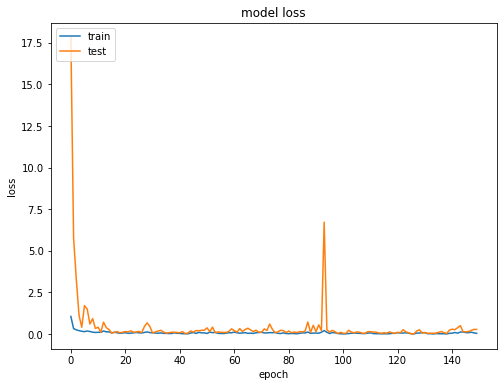

In [22]:
#plot history
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

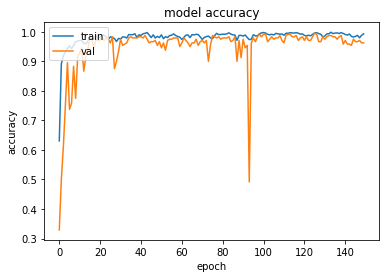

In [23]:
# Accuracy plot
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
# Load all models
import keras
model_path = '/content/drive/MyDrive/audd saved files/FSDD/models'
features = ['mel_spectrogram', 'mfcc', 'zero_crossing_rate']

feature = features[0]

mp_model = keras.models.load_model(model_path+"/{}_.h5".format(feature))
mfcc_model = keras.models.load_model(model_path+"/{}_.h5".format(feature))
zc_model = keras.models.load_model(model_path+"/{}_.h5".format(feature))

In [44]:
import numpy as np
def ensemble_models_predictions(predictions):
  """
  Parameter:
  predictions: list of prediction
  """
  ensembled_prediction = np.sum(predictions, axis=0)

  return np.argmax(ensembled_prediction, axis=1)

In [51]:
import sklearn
import keras
import sklearn.metrics as metrics
models_path = '/content/drive/MyDrive/audd saved files/FSDD/models'

x_test_mfcc = np.load('/content/drive/MyDrive/audd saved files/FSDD/x_mfcc_test.npy',allow_pickle=True)
y_test_mfcc = np.load('/content/drive/MyDrive/audd saved files/FSDD/y_mfcc_test.npy',allow_pickle=True)

x_test_zcr = np.load('/content/drive/MyDrive/audd saved files/FSDD/x_zero_crossing_rate_test.npy',allow_pickle=True)
y_test_zcr = np.load('/content/drive/MyDrive/audd saved files/FSDD/y_zero_crossing_rate_test.npy',allow_pickle=True)

x_test_mp = np.load('/content/drive/MyDrive/audd saved files/FSDD/x_mel_spectrogram_test.npy',allow_pickle=True)
y_test_mp = np.load('/content/drive/MyDrive/audd saved files/FSDD/y_mel_spectrogram_test.npy',allow_pickle=True)


mfcc_model = keras.models.load_model(models_path+"/mfcc_.h5")
mp_model = keras.models.load_model(models_path+"/mel_spectrogram_.h5")
zcr_model = keras.models.load_model(models_path+"/zero_crossing_rate_.h5")

mfcc_predictions = mfcc_model.predict(x_test_mfcc,batch_size=10)
zcr_predictions = zcr_model.predict(x_test_zcr,batch_size=10)
mp_predictions = mp_model.predict(x_test_mp,batch_size=10)


lists = [mp_predictions, zcr_predictions]

result = ensemble_models_predictions(lists)

# calculate accuracy

acc = metrics.accuracy_score(y_test_zcr, result)
print(acc)

0.98
